### Spectral Profiles

This notebook is for creating spectral profiles using `CIAO SHERPA` and `XSPEC`. Parts 1-4 must be done in a directory *without* spaces, within a CIAO environment. Part 5 can be done anywhere!

1. Set SDSS 1531 parameters
2. Define spectral annulus regions 
3. Create Surface Brightness Profile
4. Extract and Fit the spectra from the defined annuli
5. Redo 2-4 for the potential cold front
6. Compute Thermodynamic Profiles and compare to those obtained with `CCPIV` (in prep)

In [2]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [3]:
import os
import sys
import re
import glob
import shutil
import logging
from types import SimpleNamespace # cute trick to turn dictionaries into separate variables

import warnings
warnings.filterwarnings("ignore")

import json

import numpy as np
import numpy.polynomial.polynomial as poly

import scipy

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd

from astropy.io import fits
from astropy.io import ascii
from astropy.table import QTable
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import FlatLambdaCDM
import pyregion
from astropy.wcs import WCS

# # Run CIAO within Python! 
# import ciao_contrib.runtool as ciao
# from sherpa.astro import ui as sherpa
# from sherpa.astro import xspec as xspec
# import lightcurves as lc
# from pycrates import read_file

import multiprocessing

import importlib




In [7]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
#uncomment and run in ciao environment if running 1-4
import chandra_functions as cf
import science_functions as sf

In [4]:
#uncomment if need to reload module
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

## Set SDSS 1531 Specific Parameters

In [4]:
obsids = ['17218', '18689']
nH = 1.79e20 
kT_guess = 4.0 # keV
abundance_guess = 0.3
z = 0.335
zh = 0.335
r500 = 840 # kpc

acis_pixel_scale = 0.4920 * u.arcsec

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
angular_diameter_distance = cosmo.angular_diameter_distance(z=z) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, the angular diameter distance is {np.round(angular_diameter_distance,4)}')
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.335, the angular diameter distance is 990.0203 Mpc
At a redshift of 0.335, we have 4.7998 kpc / arcsec


## In CIAO

### Define spectral annulus regions 

Define series of annuli in DS9. we choose equally linearly spaced annuli within 60"

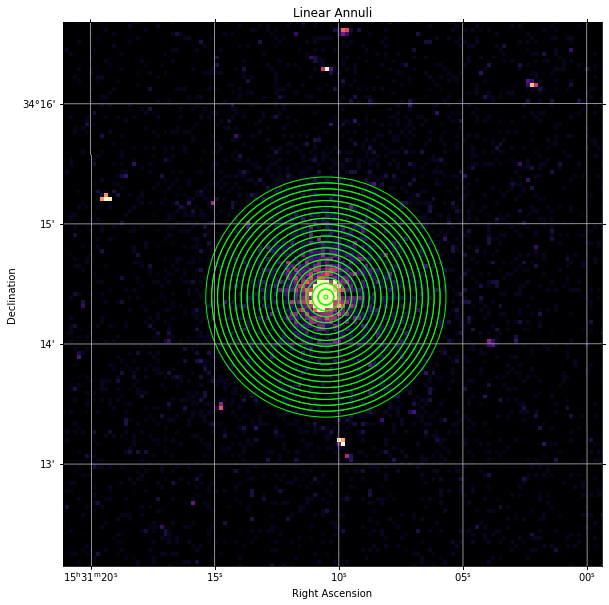

In [9]:
annuli_to_use = [path_to_beads + 'Analysis/chandraBeads/profiles_by_hand/annulus_60arcsec.reg']
annuli_labels = ['Linear Annuli']

for idf, annuli_file in enumerate(annuli_to_use):
    # Also populate a list of individual annuli in this region stack
    with open(annuli_file) as f:
        list_of_annuli_strings = [ line.strip() for line in f ]

    fig, ax = cf.show_img(path_to_beads + 'Analysis/chandraBeads/profiles_by_hand/ff.img.07-2.fits', regions=annuli_file)
    ax.set_title(annuli_labels[idf])

### Create Surface Brightness Profile

Extract the surface brightness profile using `CIAO`.
- need to create `background.reg` by drawing an annulust way outside the cluster that looks like background noise

In [7]:
annuli_id=0
for obsid in obsids: 
    print(f'Extracting radial profile for {obsid}')
    ciao.dmextract(f'{obsid}_reproj_evt.fits[energy=500:7000][bin sky=@{annuli_to_use[annuli_id]}]', 
                outfile=f'v{obsid}_flux_rprofile.fits', 
                bkg=f'{obsid}_reproj_evt.fits[energy=500:7000][bin sky=region(background.reg)]', 
                opt='generic',
                exp=f'{obsid}_broad_thresh.expmap',
                bkgexp=f'{obsid}_broad_thresh.expmap',
                clobber=True)
    print(f'Made {obsid}_flux_rprofile.fits')



Extracting radial profile for 17218
Made v17218_flux_rprofile.fits
Extracting radial profile for 18689
Made v18689_flux_rprofile.fits


In [23]:
#obtain counts per annuli
#in ciao: dmlist "18689_flux_rprofile.fits[HISTOGRAM][cols counts,net_counts]" data

a18689 = [252.54325497, 226.70079234, 288.95939035, 222.21817732,
185.47938311, 152.73630875, 174.99509572, 148.25797389,
129.51322715, 117.77201412, 135.03656467, 120.29014556,
79.54893252, 97.81515545, 86.06706396, 105.32585092,
67.59374623, 76.84398236, 87.10276932, 74.37233701,
62.62090076]

a17218 = [426.87180381, 383.13652202, 517.53000197, 408.92379943, 340.32166136,
 314.71233113, 285.10612859, 292.50680071, 274.89466029, 225.28845775,
 235.69194005, 215.07698945, 217.47078691, 183.87707939, 182.25931861,
 160.65311607, 146.06221873, 140.44164777, 154.83544523, 107.24735808,
 137.62397693]

net_counts = np.array(a17218) + np.array(a18689)
print(np.sum(net_counts), np.min(net_counts), np.max(net_counts))

8242.32511076 181.61969509 806.48939232


Text(0.5, 0, 'Radius (arcsec)')

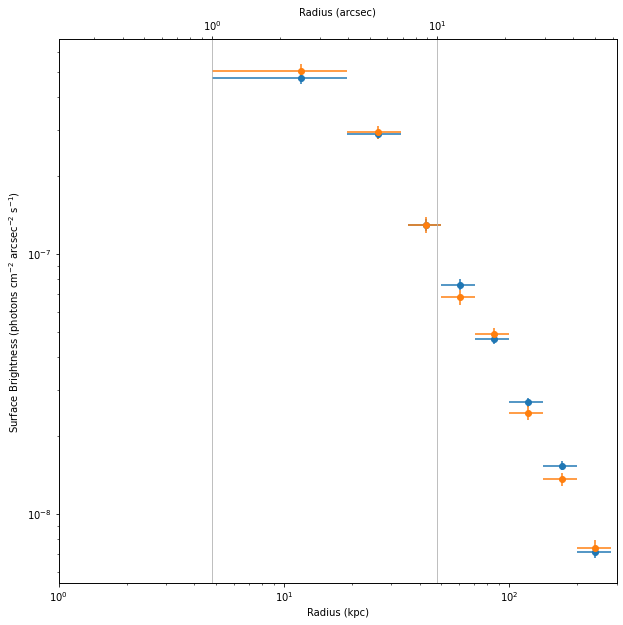

In [8]:

fig, ax = plt.subplots(figsize=(10,10))

for obsid in obsids:
    surface_brightness_profile = read_file(f'v{obsid}_flux_rprofile.fits')

    rmin_rmax_in_pixel_units = surface_brightness_profile.get_column("r").values # this will give you an array of radii
    rmid_in_pixel_units = surface_brightness_profile.get_column("rmid").values
    
    sur_bri = surface_brightness_profile.get_column("sur_bri").values
    sur_bri_err = surface_brightness_profile.get_column("sur_bri_err").values
    sur_flux = surface_brightness_profile.get_column("sur_flux").values
    sur_flux_err = surface_brightness_profile.get_column("sur_flux_err").values
    cel_flux = surface_brightness_profile.get_column("cel_flux").values # The CEL_FLUX and CEL_FLUX_ERR columns are also provided, with transforms applied to convert values in pixels to ones in arcsec (if the appropriate WCS information is provided in the input file).
    cel_flux_err = surface_brightness_profile.get_column("cel_flux_err").values


    radius_to_plot = rmid_in_pixel_units * acis_pixel_scale.value * kpc_per_arcsec.value  # convert to kpc but ditch astropy units
    radius_err_to_plot = ((rmin_rmax_in_pixel_units[:,1] - rmin_rmax_in_pixel_units[:,0])/2) * acis_pixel_scale.value * kpc_per_arcsec.value
    
    ax.errorbar(radius_to_plot, cel_flux,yerr=cel_flux_err, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Surface Brightness (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')




## 4. Extract and Fit the spectra from the defined annuli

Below we extract the spectra in each annuli using `CIAO`. 

In [11]:
really_run_this = True

if really_run_this is True:
    unique_run_name = 'sdss1531'

    #open 60 arcsec annuli
    with open(annuli_to_use[1]) as f:
            list_of_annuli_strings = [ line.strip() for line in f ]

    # Clean up existing files that conflict with this run name
    existing_run_files = glob.glob(f'*{unique_run_name}*')
    for f in existing_run_files:
        os.remove(f)


    # First, extract the spectra. This'll take a while :( 
    for i, annulus_string in enumerate(tqdm(list_of_annuli_strings)):
        
        for obsid in obsids:

            print(f'Extracting spectra from region {i} for {obsid}...') 
            ciao.specextract.punlearn()

            ciao.specextract(infile=f'{obsid}_reproj_evt.fits[sky={annulus_string}]',
                            outroot=f'{unique_run_name}_{obsid}_{i}',
                            bkgfile=f'{obsid}_reproj_evt.fits[sky=region(background.reg)]',
                            clobber=True,
                            parallel=True,
                            verbose=5)

            print(f'Created spectra and respones files: {unique_run_name}_{obsid}_{i}.*\n')
            

  0%|          | 0/8 [00:00<?, ?it/s]

Extracting spectra from region 0 for 17218...
Created spectra and respones files: avery_17218_0.*

Extracting spectra from region 0 for 18689...
Created spectra and respones files: avery_18689_0.*

Extracting spectra from region 1 for 17218...
Created spectra and respones files: avery_17218_1.*

Extracting spectra from region 1 for 18689...
Created spectra and respones files: avery_18689_1.*

Extracting spectra from region 2 for 17218...
Created spectra and respones files: avery_17218_2.*

Extracting spectra from region 2 for 18689...
Created spectra and respones files: avery_18689_2.*

Extracting spectra from region 3 for 17218...
Created spectra and respones files: avery_17218_3.*

Extracting spectra from region 3 for 18689...
Created spectra and respones files: avery_18689_3.*

Extracting spectra from region 4 for 17218...
Created spectra and respones files: avery_17218_4.*

Extracting spectra from region 4 for 18689...
Created spectra and respones files: avery_18689_4.*

Extracting

### Fit the spectra with an APEC model in Sherpa

In [12]:
unique_run_name = 'sdss1531'

kTs_list = []
kT_errs_list = []
norms_list = []
norm_errs_list = []

sherpa_log = logging.getLogger("Sherpa")
sherpa_log.setLevel(logging.ERROR)

#open 60 arcsec annuli (0) or vikhlinin annuli (1)
with open(annuli_to_use[1]) as f:
        list_of_annuli_strings = [ line.strip() for line in f ]
        
for region_number in tqdm(range(len(list_of_annuli_strings))): 

    # Load in the data and set the model for each
    print(f'Loading data and model for region {region_number}...')
    
    for i, obsid in enumerate(obsids):
        pi_file_name = f'{unique_run_name}_{obsid}_{region_number}_grp.pi'
        bkg_pi_file_name = f'{unique_run_name}_{obsid}_{region_number}_bkg.pi'
        sherpa.load_pha(i, pi_file_name)
        sherpa.load_bkg(i, bkg_pi_file_name) # 
        sherpa.subtract(i) # subtract the background
        sherpa.set_source(i, sherpa.xsphabs.phabs * sherpa.xsapec.apec)

    print(f'Fitting for region {region_number}...')

    # Set energy range to fit to
    sherpa.set_analysis('energy')
    low_energy_cutoff = 0.3  # [units: keV]
    high_energy_cutoff = 7.0  # [units: keV]
    sherpa.ignore(f":{low_energy_cutoff}, {high_energy_cutoff}:")

    # set model parameters
    phabs.nH = nH / 1e22
    apec.kT = kT_guess
    apec.Abundanc = abundance_guess
    apec.redshift = z
    apec.norm = 1.0

    # Freeze (don't fit) and thaw (fit) parameters 
    sherpa.freeze(phabs.nH, apec.redshift, apec.Abundanc)
    sherpa.thaw(apec.kT, apec.norm)
    
    # Fit the model to the data
    sherpa.fit(0,1)
    basic_fit_results = sherpa.get_fit_results()
    print(basic_fit_results)

    # Now determine confidence intervals
    sherpa.set_conf_opt('numcores', 1) # conf() multiprocessing is kinda broken, I think

    # grab the goodness-of-fit
    sherpa.calc_stat_info()
    rstat = sherpa.get_stat_info()[0].rstat

    # Warn the user if the fit is bad 
    if rstat > 3.0:
        print(f'WARNING: Goodness-of-fit for {region_number} is {rstat}, this is bad!')
    sherpa.conf()
    fit_results = sherpa.get_conf_results()

    kT = fit_results.parvals[0]
    kTs_list.append(kT) 

    kT_mean_error = (fit_results.parmins[0] + fit_results.parmaxes[0]) / 2
    kT_errs_list.append(kT_mean_error)

    norm_fit = fit_results.parvals[1]
    norms_list.append(norm_fit)
    
    norm_mean_error = (fit_results.parmins[1] + fit_results.parmaxes[1]) / 2
    norm_errs_list.append(norm_mean_error)

    kTs = np.array(kTs_list) * u.keV
    kT_errs = np.array(kT_errs_list) * u.keV
    norms = np.array(norms_list)
    norm_errs = np.array(norm_errs_list)    

    # make a plot for this fit :) 
    
    sherpa.get_data_plot_prefs()['ylog'] = True
    sherpa.get_data_plot_prefs()['xlog'] = True
    sherpa.plot_fit_delchi(0)
    sherpa.plot_fit_delchi(1, overplot=True)

    # hijack the plot axes to override title
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    axs = fig.get_axes()
    axs[0].set_title(f'{unique_run_name} region {region_number} ({np.round(radius_to_plot[1],0)} kpc) | kT = {np.round(kT,3)} ± {np.round(kT_mean_error,3)} keV | Stat = {np.round(rstat,3)}')
    plt.savefig(f'{unique_run_name}_{region_number}_fit.pdf', dpi=300)
    plt.close()
    sherpa.clean()


  0%|          | 0/8 [00:00<?, ?it/s]

Loading data and model for region 0...
read ARF file avery_17218_0.arf
read RMF file avery_17218_0.rmf
read ARF (background) file avery_17218_0_bkg.arf
read RMF (background) file avery_17218_0_bkg.rmf
read background file avery_17218_0_bkg.pi
read ARF (background) file avery_17218_0_bkg.arf
read RMF (background) file avery_17218_0_bkg.rmf
read ARF file avery_18689_0.arf
read RMF file avery_18689_0.rmf
read ARF (background) file avery_18689_0_bkg.arf
read RMF (background) file avery_18689_0_bkg.rmf
read background file avery_18689_0_bkg.pi
read ARF (background) file avery_18689_0_bkg.arf
read RMF (background) file avery_18689_0_bkg.rmf
Fitting for region 0...
Datasets              = 0, 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 4.22652e+10
Final fit statistic   = 23.6897 at function evaluation 16
Data points           = 38
Degrees of freedom    = 36
Probability [Q-value] = 0.94279
Reduced statistic     = 0.658046
Change in statistic   = 

In [13]:
#save values so dont have to run this every time
specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'

np.save(specfit_savepath + 'kTs_60', kTs_list)
np.save(specfit_savepath + 'kT_err_60', kT_errs_list)
np.save(specfit_savepath + 'norms_60', norms_list)
np.save(specfit_savepath + 'norm_errs_60', norm_errs_list)

In [ ]:
surface_brightness_profile = read_file(f'17218_flux_rprofile.fits')

rmin_rmax_in_pixel_units = surface_brightness_profile.get_column("r").values # this will give you an array of radii
rmid_in_pixel_units = surface_brightness_profile.get_column("rmid").values

sur_bri = surface_brightness_profile.get_column("sur_bri").values
sur_bri_err = surface_brightness_profile.get_column("sur_bri_err").values
sur_flux = surface_brightness_profile.get_column("sur_flux").values
sur_flux_err = surface_brightness_profile.get_column("sur_flux_err").values
cel_flux = surface_brightness_profile.get_column("cel_flux").values # The CEL_FLUX and CEL_FLUX_ERR columns are also provided, with transforms applied to convert values in pixels to ones in arcsec (if the appropriate WCS information is provided in the input file).
cel_flux_err = surface_brightness_profile.get_column("cel_flux_err").values

r_inner_in_kpc = rmin_rmax_in_pixel_units[:,0] * acis_pixel_scale * kpc_per_arcsec 
r_outer_in_kpc = rmin_rmax_in_pixel_units[:,1] * acis_pixel_scale * kpc_per_arcsec

radius_to_plot = rmid_in_pixel_units * acis_pixel_scale.value * kpc_per_arcsec.value  # convert to kpc but ditch astropy units
radius_err_to_plot = ((rmin_rmax_in_pixel_units[:,1] - rmin_rmax_in_pixel_units[:,0])/2) * acis_pixel_scale.value * kpc_per_arcsec.value




In [ ]:
radius_df = pd.DataFrame(np.transpose([radius_to_plot, radius_err_to_plot, r_inner_in_kpc.value, 
                            r_outer_in_kpc.value]), columns=['radius', 'radius_err', 'r_inner', 
                            'r_outer'])
np.save(specfit_savepath + 'radius_60', radius_df.to_numpy())

### The Potential Cold Front

First, we create a surface brightness profile to identify a discontinuity. Created a pandas region in DS9 encompassing the area between the X-ray "wings"

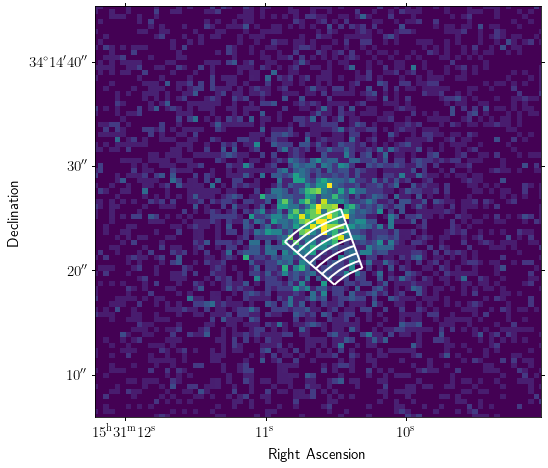

In [10]:
#plot chandra annuli 
pf.styleplots(labelsizes=15)
chandra_bin1_file = ''.join((path_to_beads, 'Analysis/chandraBeads/merged/beads_xray_bin1_broad_flux.img'))
hdu, hdr, wcs = pf.open_fits(chandra_bin1_file)
chandra_zoom = [sf.sdss1531_dict['ra']+ 6e-4, sf.sdss1531_dict['dec'], 20 * u.arcsec]

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection=WCS(hdr))
ax, cb = pf.ax_fits_map(hdu=None, data=hdu.data, hdr=hdr,
                vmin=0, vmax=3.2e-7, cmap='viridis', 
                coords=chandra_zoom, ax=ax, contour=False, 
                clip=None, location='bottom', cbar=False)

## Define the region string
region_string = """# Region file format: DS9 version 4.1
global color=white dashlist=8 3 width=2 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
panda(15:31:10.1581,+34:14:14.520,108.50316,136.74156,1,6.006",12.013",8)
"""

# add the panda region
region = pyregion.parse(region_string).as_imagecoord(hdr)
patch_list, artist_list = region.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)



In [ ]:
#surface brightness profile
annuli_to_use = ['cav_sb.reg']

# for obsid in obsids: 
annuli_id=0
obsid = 'merged'
print(f'Extracting radial profile for {obsid}')
ciao.dmextract(f'beads_xray_bin1_merged_evt.fits[energy=500:7000][bin sky=@{annuli_to_use[annuli_id]}]', 
            outfile=f'cs{obsid}_flux_rprofile.fits', 
            bkg=f'beads_xray_bin1_merged_evt.fits[energy=500:7000][bin sky=region(background.reg)]', 
            opt='generic',
            exp=f'beads_xray_bin1_broad_thresh.expmap',
            bkgexp=f'beads_xray_bin1_broad_thresh.expmap',
            clobber=True)
print(f'Made cs{obsid}_flux_rprofile.fits')




In [ ]:

fig, ax = plt.subplots(figsize=(8,8))
obsids = ['merged']
for obsid in obsids:
    surface_brightness_profile = read_file(f'cs{obsid}_flux_rprofile.fits')

    rmin_rmax_in_pixel_units = surface_brightness_profile.get_column("r").values # this will give you an array of radii
    rmid_in_pixel_units = surface_brightness_profile.get_column("rmid").values
    
    sur_bri = surface_brightness_profile.get_column("sur_bri").values
    sur_bri_err = surface_brightness_profile.get_column("sur_bri_err").values
    sur_flux = surface_brightness_profile.get_column("sur_flux").values
    sur_flux_err = surface_brightness_profile.get_column("sur_flux_err").values
    cel_flux = surface_brightness_profile.get_column("cel_flux").values # The CEL_FLUX and CEL_FLUX_ERR columns are also provided, with transforms applied to convert values in pixels to ones in arcsec (if the appropriate WCS information is provided in the input file).
    cel_flux_err = surface_brightness_profile.get_column("cel_flux_err").values


    radius_to_plot = rmid_in_pixel_units * acis_pixel_scale.value * kpc_per_arcsec.value  # convert to kpc but ditch astropy units
    radius_err_to_plot = ((rmin_rmax_in_pixel_units[:,1] - rmin_rmax_in_pixel_units[:,0])/2) * acis_pixel_scale.value * kpc_per_arcsec.value
    
    ax.errorbar(radius_to_plot, cel_flux,yerr=cel_flux_err, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Surface Brightness (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlim(28, 60)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
# ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

There is a discontinuity! Since there's not enough counts for spectral fitting in each annulus, we'll need to define bigger annuli

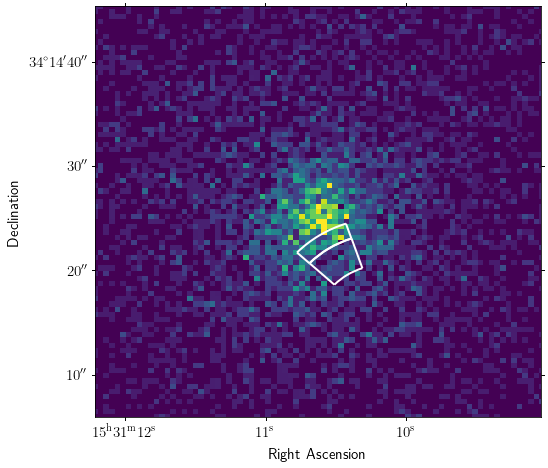

In [11]:
#ax3

#plot chandra annuli 
pf.styleplots(labelsizes=15)
chandra_bin1_file = ''.join((path_to_beads, 'Analysis/chandraBeads/merged/beads_xray_bin1_broad_flux.img'))
hdu, hdr, wcs = pf.open_fits(chandra_bin1_file)
chandra_zoom = [sf.sdss1531_dict['ra']+ 6e-4, sf.sdss1531_dict['dec'], 20 * u.arcsec]

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(projection=WCS(hdr))
ax, cb = pf.ax_fits_map(hdu=None, data=hdu.data, hdr=hdr,
                vmin=0, vmax=3.2e-7, cmap='viridis', 
                coords=chandra_zoom, ax=ax, contour=False, 
                clip=None, location='bottom', cbar=False)

## Define the region string
region_string = """# Region file format: DS9 version 4.1
global color=white dashlist=8 3 width=2 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
panda(15:31:10.1581,+34:14:14.520,108.53008,136.76848,1,6.007",9.010",1)
panda(15:31:10.1593,+34:14:14.520,108.53008,136.76848,1,9.010",10.511",1)
"""

# add the panda region
region = pyregion.parse(region_string).as_imagecoord(hdr)
patch_list, artist_list = region.get_mpl_patches_texts()
for p in patch_list:
    ax.add_patch(p)
for t in artist_list:
    ax.add_artist(t)


now time for spectral fitting

In [ ]:
annuli_to_use = ['pie_cavity_2.reg']
annuli_id=0

for obsid in obsids: 
    print(f'Extracting radial profile for {obsid}')
    ciao.dmextract(f'{obsid}_reproj_evt.fits[energy=500:7000][bin sky=@{annuli_to_use[annuli_id]}]', 
                outfile=f'cs2{obsid}_flux_rprofile.fits', 
                bkg=f'{obsid}_reproj_evt.fits[energy=500:7000][bin sky=region(background.reg)]', 
                opt='generic',
                exp=f'{obsid}_broad_thresh.expmap',
                bkgexp=f'{obsid}_broad_thresh.expmap',
                clobber=True)
    print(f'Made cs2{obsid}_flux_rprofile.fits')



In [ ]:

fig, ax = plt.subplots(figsize=(10,10))

for obsid in obsids:
    surface_brightness_profile = read_file(f'cs2{obsid}_flux_rprofile.fits')

    rmin_rmax_in_pixel_units = surface_brightness_profile.get_column("r").values # this will give you an array of radii
    rmid_in_pixel_units = surface_brightness_profile.get_column("rmid").values
    
    sur_bri = surface_brightness_profile.get_column("sur_bri").values
    sur_bri_err = surface_brightness_profile.get_column("sur_bri_err").values
    sur_flux = surface_brightness_profile.get_column("sur_flux").values
    sur_flux_err = surface_brightness_profile.get_column("sur_flux_err").values
    cel_flux = surface_brightness_profile.get_column("cel_flux").values # The CEL_FLUX and CEL_FLUX_ERR columns are also provided, with transforms applied to convert values in pixels to ones in arcsec (if the appropriate WCS information is provided in the input file).
    cel_flux_err = surface_brightness_profile.get_column("cel_flux_err").values


    radius_to_plot = rmid_in_pixel_units * acis_pixel_scale.value * kpc_per_arcsec.value  # convert to kpc but ditch astropy units
    radius_err_to_plot = ((rmin_rmax_in_pixel_units[:,1] - rmin_rmax_in_pixel_units[:,0])/2) * acis_pixel_scale.value * kpc_per_arcsec.value
    
    ax.errorbar(radius_to_plot, cel_flux,yerr=cel_flux_err, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Surface Brightness (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')




In [ ]:
really_run_this = True

if really_run_this is True:
    unique_run_name = 'cav2'

    #open 60 arcsec annuli
    with open(annuli_to_use[annuli_id]) as f:
            list_of_annuli_strings = [ line.strip() for line in f ]

    # Clean up existing files that conflict with this run name
    existing_run_files = glob.glob(f'*{unique_run_name}*')
    for f in existing_run_files:
        os.remove(f)


    # First, extract the spectra. This'll take a while :( 
    for i, annulus_string in enumerate(tqdm(list_of_annuli_strings)):
        
        for obsid in obsids:

            print(f'Extracting spectra from region {i} for {obsid}...') 
            ciao.specextract.punlearn()

            ciao.specextract(infile=f'{obsid}_reproj_evt.fits[sky={annulus_string}]',
                            outroot=f'{unique_run_name}_{obsid}_{i}',
                            bkgfile=f'{obsid}_reproj_evt.fits[sky=region(background.reg)]',
                            clobber=True,
                            parallel=True,
                            verbose=5)

            print(f'Created spectra and respones files: {unique_run_name}_{obsid}_{i}.*\n')
            

In [ ]:
unique_run_name = 'cav2'

kTs_list = []
kT_errs_list = []
norms_list = []
norm_errs_list = []

sherpa_log = logging.getLogger("Sherpa")
sherpa_log.setLevel(logging.ERROR)

#open 60 arcsec annuli (0) or vikhlinin annuli (1)
with open(annuli_to_use[annuli_id]) as f:
        list_of_annuli_strings = [ line.strip() for line in f ]
        
for region_number in tqdm(range(len(list_of_annuli_strings))): 

    # Load in the data and set the model for each
    print(f'Loading data and model for region {region_number}...')
    
    for i, obsid in enumerate(obsids):
        pi_file_name = f'{unique_run_name}_{obsid}_{region_number}_grp.pi'
        bkg_pi_file_name = f'{unique_run_name}_{obsid}_{region_number}_bkg.pi'
        sherpa.load_pha(i, pi_file_name)
        sherpa.load_bkg(i, bkg_pi_file_name) # 
        sherpa.subtract(i) # subtract the background
        sherpa.set_source(i, sherpa.xsphabs.phabs * sherpa.xsapec.apec)

    print(f'Fitting for region {region_number}...')

    # Set energy range to fit to
    sherpa.set_analysis('energy')
    low_energy_cutoff = 0.3  # [units: keV]
    high_energy_cutoff = 7.0  # [units: keV]
    sherpa.ignore(f":{low_energy_cutoff}, {high_energy_cutoff}:")

    # set model parameters
    phabs.nH = nH / 1e22
    apec.kT = kT_guess
    apec.Abundanc = abundance_guess
    apec.redshift = z
    apec.norm = 1.0

    # Freeze (don't fit) and thaw (fit) parameters 
    sherpa.freeze(phabs.nH, apec.redshift, apec.Abundanc)
    sherpa.thaw(apec.kT, apec.norm)
    
    # Fit the model to the data
    sherpa.fit(0,1)
    basic_fit_results = sherpa.get_fit_results()
    print(basic_fit_results)

    # Now determine confidence intervals
    sherpa.set_conf_opt('numcores', 1) # conf() multiprocessing is kinda broken, I think

    # grab the goodness-of-fit
    sherpa.calc_stat_info()
    rstat = sherpa.get_stat_info()[0].rstat

    # Warn the user if the fit is bad 
    if rstat > 3.0:
        print(f'WARNING: Goodness-of-fit for {region_number} is {rstat}, this is bad!')
    sherpa.conf()
    fit_results = sherpa.get_conf_results()

    kT = fit_results.parvals[0]
    kTs_list.append(kT) 

    #kT_mean_error = (fit_results.parmins[0] + fit_results.parmaxes[0]) / 2
    kT_mean_error = fit_results.parmins[0]#
    kT_errs_list.append(kT_mean_error)

    norm_fit = fit_results.parvals[1]
    norms_list.append(norm_fit)
    
    #norm_mean_error = (fit_results.parmins[1] + fit_results.parmaxes[1]) / 2
    norm_mean_error = fit_results.parmins[1]#
    norm_errs_list.append(norm_mean_error)

    kTs = np.array(kTs_list) * u.keV
    kT_errs = np.array(kT_errs_list) * u.keV
    norms = np.array(norms_list)
    norm_errs = np.array(norm_errs_list)    

    # make a plot for this fit :) 
    
    sherpa.get_data_plot_prefs()['ylog'] = True
    sherpa.get_data_plot_prefs()['xlog'] = True
    sherpa.plot_fit_delchi(0)
    sherpa.plot_fit_delchi(1, overplot=True)

    # hijack the plot axes to override title
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    axs = fig.get_axes()
    axs[0].set_title(f'{unique_run_name} region {region_number} ({np.round(radius_to_plot[1],0)} kpc) | kT = {np.round(kT,3)} ± {np.round(kT_mean_error,3)} keV | Stat = {np.round(rstat,3)}')
    plt.savefig(f'{unique_run_name}_{region_number}_fit.pdf', dpi=300)
    plt.close()
    sherpa.clean()


In [ ]:
#save values so dont have to run this every time
specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'

np.save(specfit_savepath + 'kTs_cav', kTs_list)
np.save(specfit_savepath + 'kT_err_cav', kT_errs_list)
np.save(specfit_savepath + 'norms_cav', norms_list)
np.save(specfit_savepath + 'norm_errs_cav', norm_errs_list)

## Out of CIAO

### Compute Thermodynamic Profiles and compare to CCPIV Profiles

And compare to CCPIV profiles!

Also read in the Vikhlihin temperature profile from the Beads directory. This is all annoying, so I'm hiding these cells for cleanliness. You need to set your specific path to the final CCCPIV profiles here: 

#### Load Spectral Fits

If you've run 1-4 already, you should be free from CIAO and should just load your fits directly!

In [6]:
#Load By Hand Profiles

specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'

#KT and norm
kTs = np.load(specfit_savepath + 'kTs_60.npy') * u.keV
kT_errs = np.load(specfit_savepath + 'kT_err_60.npy') * u.keV
norms = np.load(specfit_savepath + 'norms_60.npy')
norm_errs = np.load(specfit_savepath + 'norm_errs_60.npy')

specfit_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'
radius_df = pd.DataFrame(np.load(specfit_savepath + 'radius_60.npy'), columns=['radius', 
                            'radius_err', 'r_inner', 'r_outer'])

r_inner_in_kpc = radius_df['r_inner'].to_numpy() * u.kpc 
r_outer_in_kpc = radius_df['r_outer'].to_numpy() * u.kpc 
radius_to_plot = radius_df['radius'].to_numpy() * u.kpc 
radius_err_to_plot = radius_df['radius_err'].to_numpy() * u.kpc 

volume = (4/3) * scipy.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

#electron density
electron_density = np.sqrt((norms * u.cm**-5 * 4 * np.pi * 
                            np.power(angular_diameter_distance.to(u.cm) * (1 + zh), 2)) 
                            / (1.e-14 * 0.82 * volume.to(u.cm**3))) 
electron_density_err = electron_density / (2*norms) * norm_errs

#pressure
pressure = (1.83 * electron_density * kTs).to(u.dyne/u.cm**2)
pressure_err  = pressure * sf.dm_error_prop([electron_density, kTs], [electron_density_err, kT_errs])

#entropy
entropy  = kTs * np.power(electron_density, -2.0/3.0)
entropy_err = entropy * sf.dm_error_prop([kTs.value, np.power(electron_density, -2/3).value], 
                [kT_errs.value, sf.exp_error_prop(electron_density, electron_density_err, -2/3) ])

#cooling time
cooling_time = sf.tcool(electron_density, kTs)
cool_func_err = sf.dm_error_prop([kTs**-1.7, kTs**0.5], [sf.exp_error_prop(kTs, kT_errs, -1.7), 
                    sf.exp_error_prop(kTs, kT_errs, 0.5)]) * sf.coolingFunction(kTs)

cooling_time_err = cooling_time * sf.dm_error_prop([pressure.value, np.power(electron_density, 2).value, sf.coolingFunction(kTs).value],
                    [pressure_err.value, sf.exp_error_prop(electron_density, electron_density_err, 2).value, cool_func_err])




#### Read in CCCPIV profiles


In [8]:
#load ccpiv profiles
profile_savepath = path_to_beads + 'Analysis/chandraBeads/ciao_spectra_results/'

cccpiv_profiles = pd.DataFrame(np.load(profile_savepath + 'cccpiv_thermodynamic_profiles.npy', allow_pickle=True))
cccpiv_sb_profile = pd.DataFrame(np.load(profile_savepath + 'cccpiv_sb_profile.npy', allow_pickle=True))
cccpiv_sb_profile_fit = pd.DataFrame(np.load(profile_savepath + 'cccpiv_sb_profile_fit.npy', allow_pickle=True))

cp_radius = cccpiv_profiles.radius_kpc * u.kpc
cp_gas_mass = cccpiv_profiles.gas_mass_msun * u.Msun
cp_temperature = cccpiv_profiles.temperature_kev * u.keV
cp_pressure = (cccpiv_profiles.pressure_kev_cm3 * u.keV/u.cm**3).to(u.dyne/u.cm**2)
cp_entropy = cccpiv_profiles.entropy_kev_cm2 * u.keV * u.cm**2
cp_cooling_time = cccpiv_profiles.cooling_time_gyr * u.Gyr


#### Plot Vikhlinin Surface Brightness Profile

Text(0.5, 0, 'Radius (arcsec)')

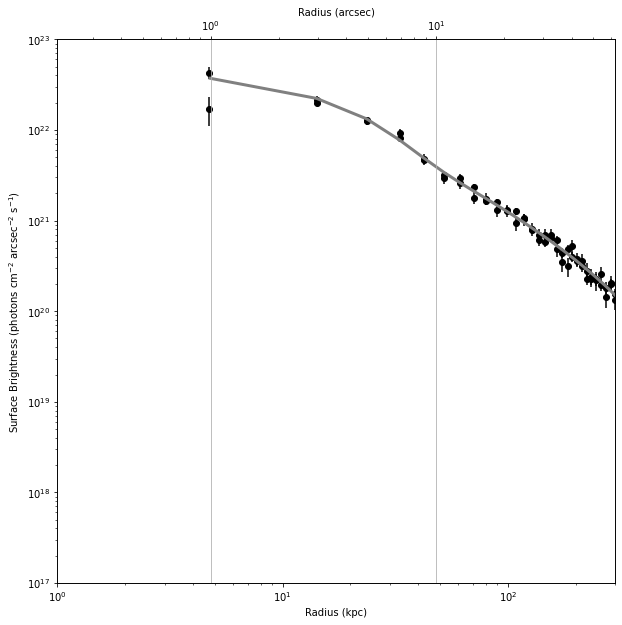

In [10]:

fig, ax = plt.subplots(figsize=(10,10))

ax.errorbar(cccpiv_sb_profile.r_kpc_17218,cccpiv_sb_profile.emission_measure_17218, 
            yerr=cccpiv_sb_profile.emission_measure_err_17218, ls='none', 
            marker='o', color='k')

ax.errorbar(cccpiv_sb_profile.r_kpc_18689,cccpiv_sb_profile.emission_measure_18689, 
            yerr=cccpiv_sb_profile.emission_measure_err_17218, ls='none', 
            marker='o', color='k')
        # ax2.fill_between(x, y - err, y + err, color=colors[i], alpha = 0.1)
        # ax2.plot(x, y, c = 'k', ls='none', marker='o')

sb_fit_x = cccpiv_sb_profile_fit.r_fit
sb_fit_y = cccpiv_sb_profile_fit.emission_measure_fit

ax.plot(sb_fit_x, sb_fit_y, lw=3, zorder=3, 
            color='gray', label='Vikhlinin+06 fit')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Surface Brightness (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)
ax.set_ylim(1e17,1e23)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')




#### Compare Tprofile

Text(0.5, 1.0, 'SDSS 1531 X-ray Temperature Profile (two-method comparison)')

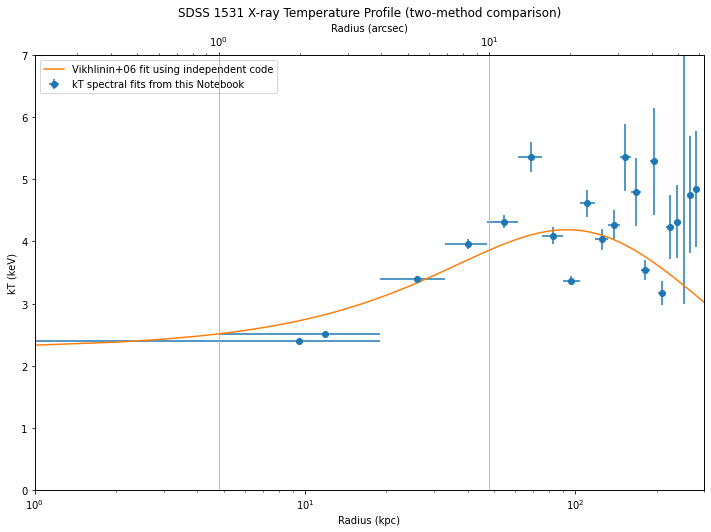

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, kTs,yerr=kT_errs, xerr=radius_err_to_plot, marker="o", ls='none', label='kT spectral fits from this Notebook') # ls=None doesn't work, stupidly

ax.set_xscale('log')


ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"kT (keV)") # for sur_bri units


# Also plot the Vikhlinin profiles for sanity
ax.plot(cp_radius, cp_temperature, label='Vikhlinin+06 fit using independent code')


ax.set_xlim(1, 300)
ax.set_ylim(0, 7)


ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')

ax2.set_xlabel('Radius (arcsec)')

ax.legend()

ax.set_title('SDSS 1531 X-ray Temperature Profile (two-method comparison)')


Good! The spectral fits are completely consistent with the VO6 code results, which are totally custom and separate from this notebook

#### Compare electron density

Compute normalization

Text(0.5, 0, 'Radius (arcsec)')

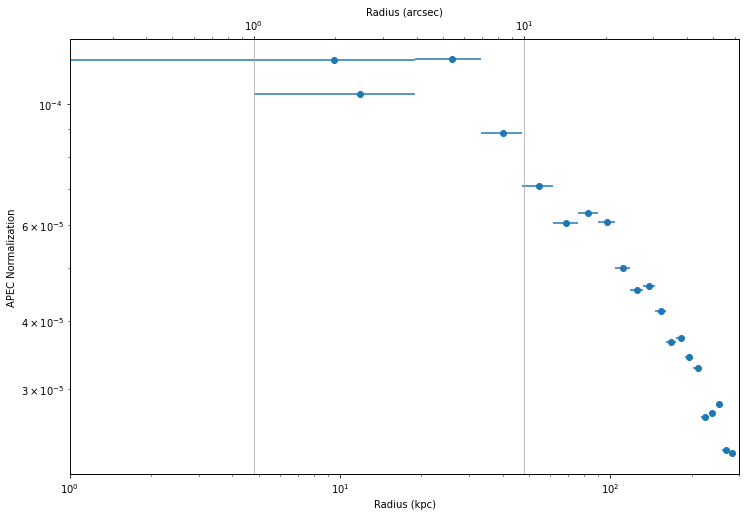

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, norms,yerr=norm_errs, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly

ax.set_xscale('log')


ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"APEC Normalization") 

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')


Compute the volume per annulus, which we need to convert norm to density

In [10]:
volume = (4/3) * scipy.pi * (r_outer_in_kpc**3 - r_inner_in_kpc**3)

Compute the density array


`Apec` model normalization is $\eta = \frac{10^{-14}}{4\pi D_A^2(1+z)^2} \int n_e n_p dV$

This is related tot he e;ectron density as 

$$ n_e = \sqrt{10^{14} \Big(\frac{4\pi \cdot N(r) \cdot [D_A \cdot (1+z)^2]}{0.82\cdot V}} $$

In [13]:
norms = norms * u.cm**-5 

In [16]:
electron_density = np.sqrt(1e14 * (4 * np.pi * norms * (angular_diameter_distance * (1 + zh))**2) / (0.82 * volume)).cgs

electron_density_err = electron_density / (2*norms) * norm_errs


In [17]:
#Load ACCEPT Table
path_accept = path_to_beads + 'Analysis/chandraBeads/profiles_by_hand/'
main_accept_table = sf.parse_accept_table(path_accept + 'accept_main_table.txt')
grouped_accept_table = main_accept_table.group_by('Name')

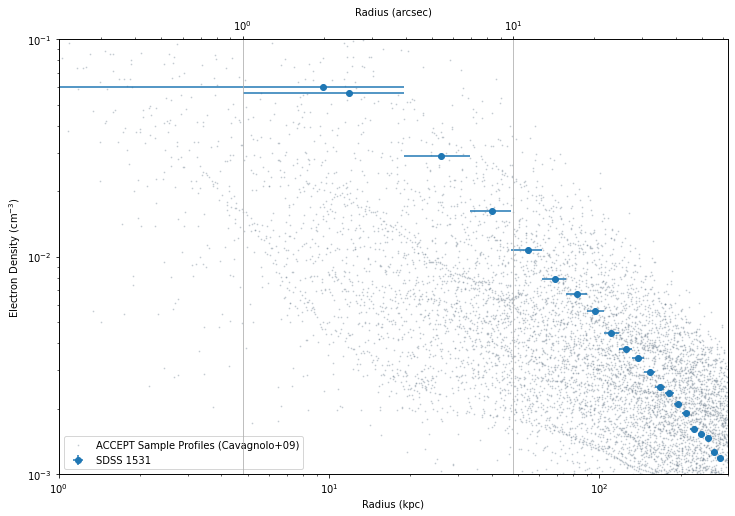

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, electron_density.value, xerr=radius_err_to_plot, yerr=electron_density_err.value, marker="o", ls='none', label='SDSS 1531') # ls=None doesn't work, stupidly

ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Electron Density (cm$^{-3}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

# #vikhlinin
# ax.plot(r, n_e, lw=3, label='v06')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    ax.plot(accept_radius, cluster_profile['nelec'], zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Sample Profiles (Cavagnolo+09)' if i==0 else '')

ax.set_ylim(1e-3, 1e-1)

legend = ax.legend()

# the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
for lh in legend.legendHandles: 
    try:
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(10)
    except AttributeError:
        # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
        continue


#### Compare pressure profiles

$P = nkT$ where $n=n_e + n_H \approx 1.83n_e$ because $n_e = \sqrt{n_en_p/0.92}$ and $n_H = 0.83 n_e$

In [19]:
#pressure
pressure = (1.83 * electron_density * kTs).to(u.dyne/u.cm**2)
pressure_err  = pressure * sf.dm_error_prop([electron_density, kTs], [electron_density_err, kT_errs])


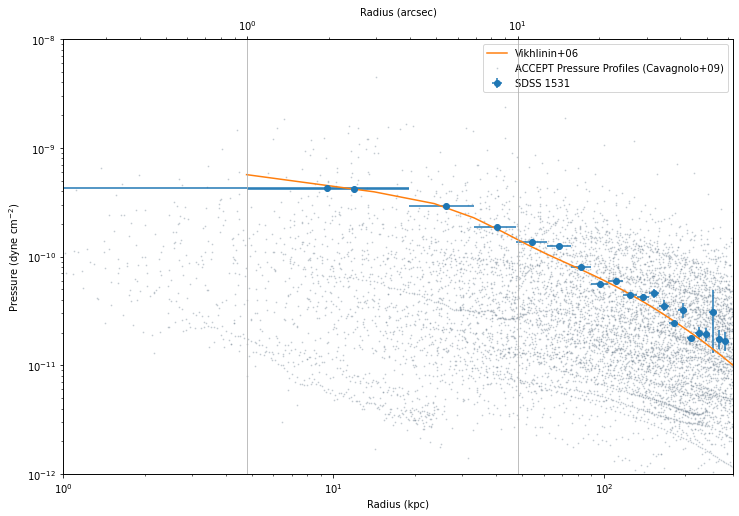

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, pressure.to(u.dyne/u.cm**2).value, xerr=radius_err_to_plot,yerr=pressure_err.value, marker="o", ls='none', label='SDSS 1531') # ls=None doesn't work, stupidly

ax.plot(cp_radius, cp_pressure, label='Vikhlinin+06')
ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Pressure (dyne cm$^{-2}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

# #vikhlinin
# ax.plot(r, vpressure_profile, lw=3, label='v06')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

ax.set_ylim(1e-12, 1e-8)


for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    ax.plot(accept_radius, cluster_profile['Pitpl'], zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Pressure Profiles (Cavagnolo+09)' if i==0 else '')

legend = ax.legend()

# the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
for lh in legend.legendHandles: 
    try:
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(10)
    except AttributeError:
        # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
        continue

#### Compare Entropy Profiles

In [21]:
#entropy
entropy  = kTs * np.power(electron_density, -2.0/3.0)
entropy_err = entropy * sf.dm_error_prop([kTs.value, np.power(electron_density, -2/3).value], 
                [kT_errs.value, sf.exp_error_prop(electron_density, electron_density_err, -2/3) ])

# # vikhlinin
# ventropy_profile = t_kev * n_e**(-2/3)

(1, 10000)

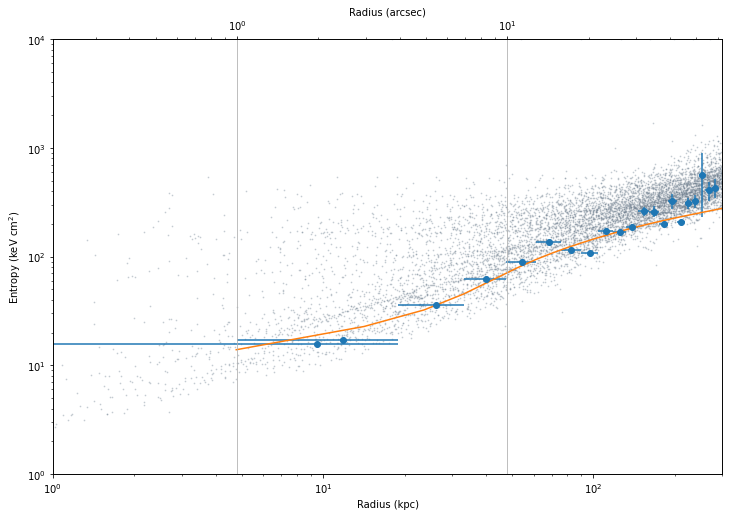

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, entropy.value, xerr=radius_err_to_plot, yerr=entropy_err.value, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_entropy, label='Vikhlinin+06')
ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Entropy (keV cm$^{2}$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

#vikhlinin
# ax.plot(r, ventropy_profile, lw=3, label='v06')

for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc

    # # if you want the smooth, clean polynomial fit profiles, which *can* have unphysical behavior at low radii 
    # r_fit, temperature_fit, pressure_fit, electron_density_fit, entropy_fit, tcool_fit, t_fit_err, p_fit_err, ed_fit_err, en_fit_err, tcool_fit_err= cf.fit_accept_clusters(cluster_profile)
    
    # ax.plot(r_fit*1000, entropy_fit, color='slategray', lw=0.3, alpha=0.2)
    ax.plot(accept_radius, cluster_profile['Kitpl'], zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Entropy Profiles (Cavagnolo+09)' if i==0 else '')

# legend = ax.legend()

# # the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
# for lh in legend.legendHandles: 
#     try:
#         lh._legmarker.set_alpha(1)
#         lh._legmarker.set_markersize(10)
#     except AttributeError:
#         # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
#         continue
ax.set_ylim(1, 10000)

#### Compare Gas Mass

In [14]:
A, Z = 1.397, 1.199
rho_g = (const.m_p * electron_density * A/Z).cgs
rho_g_err = rho_g * sf.dm_error_prop([electron_density.value], 
                [electron_density_err.value])
gas_mass = (rho_g * (4/3 * np.pi * radius_to_plot**3)).to(u.solMass)
gas_mass_err = gas_mass * sf.dm_error_prop([rho_g.value], rho_g_err.value)

cp_rho_g = (cp_gas_mass/(4/3 * np.pi * cp_radius**3)).cgs



Text(0.5, 0, 'Radius (arcsec)')

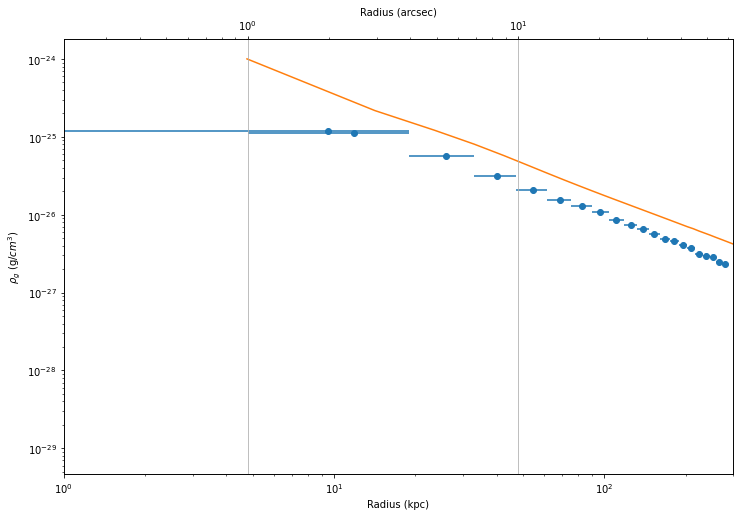

In [38]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, rho_g, xerr=radius_err_to_plot, yerr=rho_g_err, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_rho_g, label='Vikhlinin+06')
ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"$\rho_g$ (g/$cm^3$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')


Text(0.5, 0, 'Radius (arcsec)')

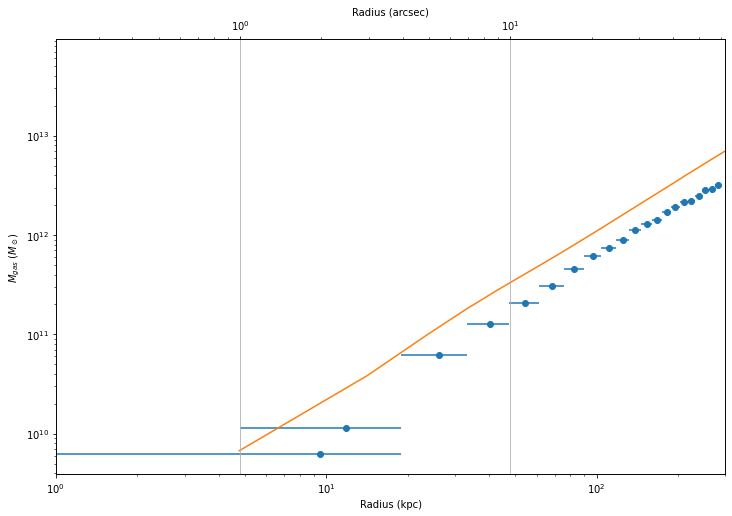

In [42]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, gas_mass, xerr=radius_err_to_plot, yerr=gas_mass_err, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_gas_mass, label='Vikhlinin+06')
ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"$M_{gas}$ ($M_\odot$)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

#### Compare Total Mass Estimates

In [57]:
def M_r(T, rho_g, r):
    """ 
    Vikhlinin (2006) eqn 7
    T in Kev, rho_g in solmass/mpc^3 and radius in Mpc
    """
    dln_rho_g = np.gradient(np.log(rho_g)) / np.gradient(np.log(r)) 

    dln_T = np.gradient(np.log(T)) / np.gradient(np.log(r))

    return -3.68e13 * T * r * (dln_rho_g + dln_T) 

In [58]:
total_mass = M_r(kTs.to(u.keV).value, rho_g.to(u.solMass/u.Mpc**3).value, radius_to_plot.to(u.Mpc).value) * u.solMass

In [69]:
np.save(specfit_savepath + 'total_mass_60', total_mass.value)

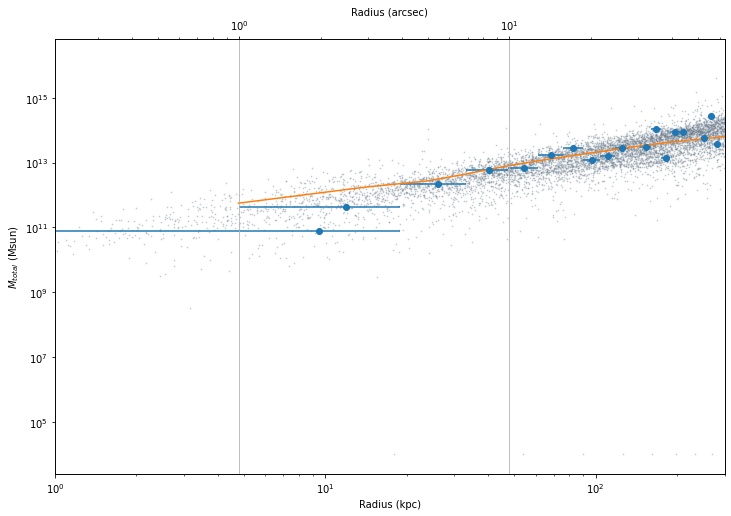

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, total_mass, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_total_mass, label='Vikhlinin+06')
ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"$M_{total}$ (Msun)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')


for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc

    # # if you want the smooth, clean polynomial fit profiles, which *can* have unphysical behavior at low radii 
    # r_fit, temperature_fit, pressure_fit, electron_density_fit, entropy_fit, tcool_fit, t_fit_err, p_fit_err, ed_fit_err, en_fit_err, tcool_fit_err= cf.fit_accept_clusters(cluster_profile)
    
    # ax.plot(r_fit*1000, entropy_fit, color='slategray', lw=0.3, alpha=0.2)
    ax.plot(accept_radius, cluster_profile['Mgrav'], zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Entropy Profiles (Cavagnolo+09)' if i==0 else '')

# # legend = ax.legend()

# # the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
# for lh in legend.legendHandles: 
#     try:
#         lh._legmarker.set_alpha(1)
#         lh._legmarker.set_markersize(10)
#     except AttributeError:
#         # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
#         continue
# ax.set_ylim(1, 10000)

#### Compare Cooling Times

What is all of this?! See Eqn. 35 here: https://arxiv.org/pdf/0706.1274.pdf

In [17]:
#cooling time
cooling_time = sf.tcool(electron_density, kTs)
cool_func_err = sf.dm_error_prop([kTs**-1.7, kTs**0.5], [sf.exp_error_prop(kTs, kT_errs, -1.7), 
                    sf.exp_error_prop(kTs, kT_errs, 0.5)]) * sf.coolingFunction(kTs)

cooling_time_err = cooling_time * sf.dm_error_prop([pressure.value, np.power(electron_density, 2).value, sf.coolingFunction(kTs).value],
                    [pressure_err.value, sf.exp_error_prop(electron_density, electron_density_err, 2).value, cool_func_err])


Text(2, 2, 'Cool Core within inner ~60 kpc')

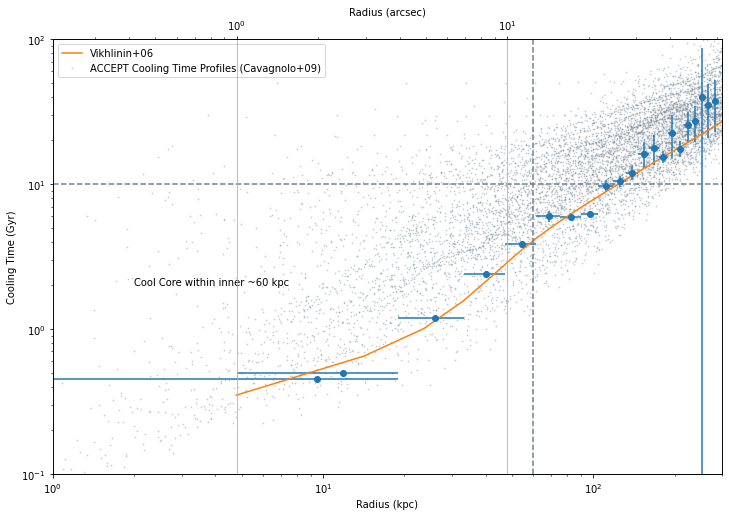

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, cooling_time.to(u.Gyr).value, xerr=radius_err_to_plot, yerr=cooling_time_err.to(u.Gyr).value, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_cooling_time, label='Vikhlinin+06')

ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Cooling Time (Gyr)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

# #vikhlinin
# ax.plot(r, (vcooling_time).to(u.Gyr), lw=3, label='v06')


for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc

    # # if you want the smooth, clean polynomial fit profiles, which *can* have unphysical behavior at low radii 
    # r_fit, temperature_fit, pressure_fit, electron_density_fit, entropy_fit, tcool_fit, t_fit_err, p_fit_err, ed_fit_err, en_fit_err, tcool_fit_err= cf.fit_accept_clusters(cluster_profile)

    # ax.plot(r_fit*1000, tcool_fit.to(u.Gyr), color='slategray', lw=0.3, alpha=0.2)
    ax.plot(accept_radius, cluster_profile['tcool32'], zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Cooling Time Profiles (Cavagnolo+09)' if i==0 else '')

legend = ax.legend()

# the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
for lh in legend.legendHandles: 
    try:
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(10)
    except AttributeError:
        # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
        continue

ax.set_ylim(0.1, 100)
ax.axhline(10, color='slategray', linestyle='--')
ax.axvline(60, color='slategray', linestyle='--')
ax.text(2, 2, 'Cool Core within inner ~60 kpc')


#### Compare Freefall Times

In [60]:
def t_ff(mass, radius):
    return np.sqrt((2 * radius**3)/(const.G * mass))

cp_freefall_time = t_ff(cp_total_mass, cp_radius)
freefall_time = t_ff(total_mass, radius_to_plot)

cp_tcool_tff_ratio = (cp_cooling_time/cp_freefall_time).cgs
tcool_tff_ratio = (cooling_time/freefall_time).cgs

Text(2, 2, 'Cool Core within inner ~60 kpc')

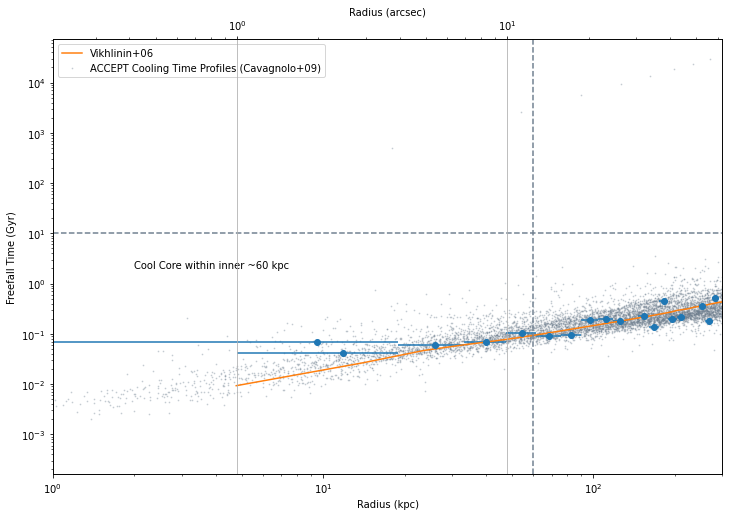

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, freefall_time.to(u.Gyr).value, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_freefall_time.to(u.Gyr).value, label='Vikhlinin+06')

ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Freefall Time (Gyr)") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

# #vikhlinin
# ax.plot(r, (vcooling_time).to(u.Gyr), lw=3, label='v06')


for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2).to(u.kpc) # Table radii are in Mpc

    # # if you want the smooth, clean polynomial fit profiles, which *can* have unphysical behavior at low radii 
    # r_fit, temperature_fit, pressure_fit, electron_density_fit, entropy_fit, tcool_fit, t_fit_err, p_fit_err, ed_fit_err, en_fit_err, tcool_fit_err= cf.fit_accept_clusters(cluster_profile)

    # ax.plot(r_fit*1000, tcool_fit.to(u.Gyr), color='slategray', lw=0.3, alpha=0.2)
    ax.plot(accept_radius, t_ff(cluster_profile['Mgrav'], accept_radius).to(u.Gyr), zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Cooling Time Profiles (Cavagnolo+09)' if i==0 else '')

legend = ax.legend()

# the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
for lh in legend.legendHandles: 
    try:
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(10)
    except AttributeError:
        # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
        continue

# ax.set_ylim(0.1, 100)
ax.axhline(10, color='slategray', linestyle='--')
ax.axvline(60, color='slategray', linestyle='--')
ax.text(2, 2, 'Cool Core within inner ~60 kpc')


Text(2, 2, 'Cool Core within inner ~60 kpc')

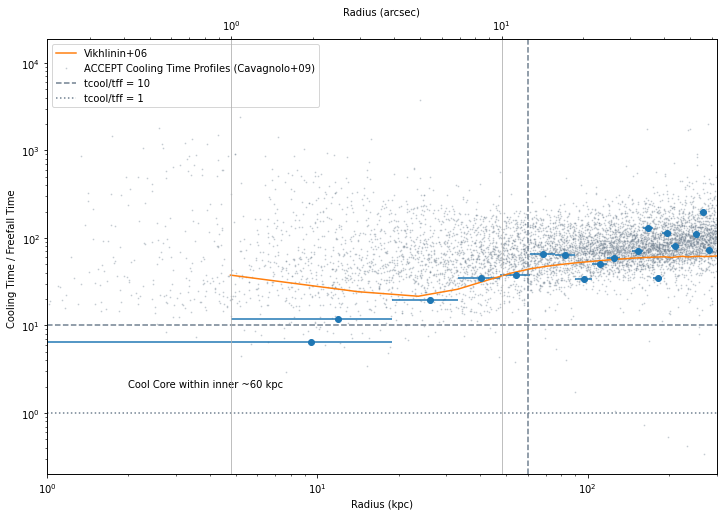

In [63]:
#ratio of tcool/tff
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(radius_to_plot, tcool_tff_ratio, xerr=radius_err_to_plot, marker="o", ls='none') # ls=None doesn't work, stupidly
ax.plot(cp_radius, cp_tcool_tff_ratio, label='Vikhlinin+06')

ax.set_xscale('log')

ax.set_xlabel("Radius (kpc)")
ax.set_ylabel(r"Cooling Time / Freefall Time ") # for sur_bri units
# ax.set_ylabel(r"Flux (photons cm$^{-2}$ arcsec$^{-2}$ s$^{-1}$)") # for flux units

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 300)

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim() / kpc_per_arcsec.value)
ax2.grid(None)
ax2.set_xscale('log')
ax2.set_xlabel('Radius (arcsec)')

# #vikhlinin
# ax.plot(r, (vcooling_time).to(u.Gyr), lw=3, label='v06')


for i, (cluster_name, cluster_profile) in enumerate(zip(grouped_accept_table.groups.keys, grouped_accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2).to(u.kpc) # Table radii are in Mpc

    # # if you want the smooth, clean polynomial fit profiles, which *can* have unphysical behavior at low radii 
    # r_fit, temperature_fit, pressure_fit, electron_density_fit, entropy_fit, tcool_fit, t_fit_err, p_fit_err, ed_fit_err, en_fit_err, tcool_fit_err= cf.fit_accept_clusters(cluster_profile)

    # ax.plot(r_fit*1000, tcool_fit.to(u.Gyr), color='slategray', lw=0.3, alpha=0.2)
    ax.plot(accept_radius, (cluster_profile['tcool32']/t_ff(cluster_profile['Mgrav'], accept_radius)).cgs, zorder=1, alpha=0.3, color='slategray', linestyle='none', marker='o', markersize=0.8, label='ACCEPT Cooling Time Profiles (Cavagnolo+09)' if i==0 else '')



# the ACCEPT data points are tiny and quasi-transparent, making for terrible legend markers. Fix that manually
for lh in legend.legendHandles: 
    try:
        lh._legmarker.set_alpha(1)
        lh._legmarker.set_markersize(10)
    except AttributeError:
        # then you've hit the handles for the SDSS points - ax.errorbar doesn't have _legmarker attribute. just skip. 
        continue

# ax.set_ylim(0.1, 100)
ax.axhline(10,  color='slategray', ls='--', lw=1.5, label='tcool/tff = 10')
ax.axhline(1,  color='slategray', ls=':', lw=1.5, label='tcool/tff = 1')
legend = ax.legend()
ax.axvline(60, color='slategray', linestyle='--')
ax.text(2, 2, 'Cool Core within inner ~60 kpc')

